In [1]:
import sympy as sp
import numpy as np
import mainframe as mf
import nuclei_func as nf
from mainframe import Region
from IPython.display import display, Latex

In [2]:
################################################################################
# INPUT DATA
################################################################################
micro_abs_water = nf.mixture([0.33, 4.2],[2, 1]) 
micro_abs_U235 = 101 
micro_fiss_U235 = 678 

density_water = 1
density_U235 = 19.1

# Defining the temperature correction factor
def T_correction(T_new):
    return np.sqrt(293/(T_new+273))

# Defining the macroscopic cross sections
macro_abs_water = nf.macro(micro_abs_water, density_water, 18) * T_correction(60)
macro_abs_U235 = nf.macro(micro_abs_U235, density_U235, 235) * T_correction(60)
macro_fiss_U235 = nf.macro(micro_fiss_U235, density_U235, 235) * T_correction(60)

# Defining the enrichment as a symbol
qual = sp.symbols('qual', positive=True, real=True)

# Defining the macroscopic cross sections of the mixtures
macro_abs_refl = nf.mixture([macro_abs_water, 0], [1, 0])
macro_fiss = nf.mixture([macro_fiss_U235, 0], [qual, 1-qual])
macro_abs_core = nf.mixture([macro_abs_water, macro_abs_U235], [1-qual, qual])

################################################################################
# Defining the regions
################################################################################
Core_1 = Region(
    Diff=0.16, 
    Abs=macro_abs_core, 
    Fiss=macro_fiss, 
    Nu=2.44, 
    Pos1=0, 
    Pos2=25, 
    composition='c', 
    power=25*50
)

Reflector_1 = Region(
    Diff=0.16, 
    Abs=macro_abs_refl, 
    Fiss=0, 
    Nu=0, 
    Pos1=25, 
    Pos2=sp.oo, 
    composition='r', 
    power=0
)
regions = [Core_1, Reflector_1]

################################################################################
# Criticality Cond
################################################################################
# Finding the core region
for region in regions:
    if region.Composition == 'c':
        core = region

# Calculating the material and geometry buckling
material_buckling = (core.Nu * macro_fiss - macro_abs_core) / core.Diffusion
width = core.End - core.Start
extrapolation_length = width + 0.7/core.Diffusion
geometry_buckling = (3.14159 / extrapolation_length)**2

# Solving the criticality equation
criticality_cond = sp.Eq(material_buckling, geometry_buckling, evaluate=False)
solve_crit = sp.solve(criticality_cond, qual)[0]
print("U235 enrichment for criticality: ", solve_crit)

# Substituting the value of qual in the macroscopic cross sections
macro_fiss = macro_fiss.subs(qual, solve_crit)
macro_abs_core = macro_abs_core.subs(qual, solve_crit)

# Updating the macroscopic cross sections
Core_1.Absorption = macro_abs_core
Core_1.Fission = macro_fiss

################################################################################
# Displaying the results
################################################################################
display(Latex(r'$\Sigma_{f} = ' + sp.latex(macro_fiss) + r'$'))
display(Latex(r'$\Sigma_{a, core} = ' + sp.latex(macro_abs_core) + r'$'))
display(Latex(r'$\Sigma_{a, refl} = ' + sp.latex(macro_abs_refl) + r'$'))

The sum of the qualites values is not 1, at line 4, default behaviour is ignoring.
U235 enrichment for criticality:  0.00215968108637319


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [3]:
# For debug output
equations, fluxes, boundaries, interfaces, powers = mf.main(regions, Symmetric=True)

# Solving the problem
# Capture output to hide debug prints
# from IPython.utils.io import capture_output

# with capture_output() as captured:
#     equations, fluxes, boundaries, interfaces, powers = mf.main(regions)

The region 1 spanning from 0 to 25 is a boundary region
Region 1 is symmetric
The region 2 spanning from 25 to oo is a boundary region
Applying boundary condition at x = oo
Term C_4*exp((x - 25)/L_2) has infinity at x = oo
The regions 1 and 2 are adjacent at 25
Diffusion equations:
Eq(Bg_1**2*phi_1(x) + Derivative(phi_1(x), (x, 2)), 0)
Eq(Derivative(phi_2(x), (x, 2)) - phi_2(x)/L_2**2, 0)

Fluxes:
Eq(phi_1(x), C_1*sin(Bg_1*x) + C_2*cos(Bg_1*x))
Eq(phi_2(x - 25), C_3*exp(-(x - 25)/L_2) + C_4*exp((x - 25)/L_2))

Boundary conditions:
Eq(Bg_1*C_1, 0)
Eq(C_4, 0)

Interface conditions:
Eq(C_1*sin(Bg_1*x_1) + C_2*cos(Bg_1*x_1), C_3*exp(-(x_1 - 25)/L_2) + C_4*exp((x_1 - 25)/L_2))
Eq(-D_1*(Bg_1*C_1*cos(25*Bg_1) - Bg_1*C_2*sin(25*Bg_1)), -D_2*(-C_3/L_2 + C_4/L_2))

Power conditions:
Eq(-2.27802314903964e-12*C_1*cos(25*Bg_1)/Bg_1 + 2.27802314903964e-12*C_1/Bg_1 + 2.27802314903964e-12*C_2*sin(25*Bg_1)/Bg_1, 1250)


In [4]:
# Print the equations
print('Diffusion equations:')
for eq in equations:
    display(Latex("$" + sp.latex(eq) + "$"))

Diffusion equations:


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [5]:
# Print the fluxes
print('\nFluxes:')
for flux in fluxes:
    display(Latex("$" + sp.latex(flux) + "$"))


Fluxes:


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [6]:
# Print the boundary conditions
print('\nBoundary conditions:')
for boundary in boundaries:
    display(Latex("$" + sp.latex(boundary) + "$"))


Boundary conditions:


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [7]:
# Print the interface conditions
print('\nInterface conditions:')
for interface in interfaces:
    display(Latex("$" + sp.latex(interface) + "$"))


Interface conditions:


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [8]:
# Print the power conditions
print('\nPower conditions:')
for power in powers:
    display(Latex("$" + sp.latex(power) + "$"))


Power conditions:


<IPython.core.display.Latex object>

In [9]:
# Call the compute function
system = mf.compute(fluxes, boundaries, interfaces, powers, regions)
print('\nSimplified system:')
for eq in system:
    display(Latex("$" + sp.latex(eq) + "$"))

Zero constant found in Eq(Bg_1*C_1, 0) is ['C_1']
Zero constant found in Eq(C_4, 0) is ['C_4']
Region 1 has B = 0.106947744680855
Substitution dictionary for region 1: {L_1: 0.993190847015114, Bg_1: 0.106947744680855, D_1: 0.16, A_1: 0.162201387730148, F_1: 0.0672259995675901, N_1: 2.44, x_1: 25, C_1: 0}
Region 2 has B = 0.976333324543103*I
Substitution dictionary for region 2: {L_2: 1.02424036429154, Bg_2: 0.976333324543103*I, D_2: 0.16, A_2: 0.15251628169814208, F_2: 0, N_2: 0, x_2: oo, C_4: 0}

Simplified system:


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [10]:
# Get rid of True expressions
system = [eq for eq in system if eq != True]

# Get all the unkowns
all_symbols = set()
for eq in system:
    all_symbols.update(eq.free_symbols)

x = sp.symbols('x')
all_symbols.discard(x)

unkowns = [flux.lhs for flux in fluxes]
for i in all_symbols:
    unkowns.append(i)

display(unkowns)
display(system)

[phi_1(x), phi_2(x - 25), C_3, C_2]

[Eq(phi_1(x), C_2*cos(0.106947744680855*x)),
 Eq(phi_2(x - 25), 39847803185.6426*C_3*exp(-0.976333324543103*x)),
 Eq(-0.892517817307993*C_2, C_3),
 Eq(0.00771755690345527*C_2, 0.156213331926896*C_3),
 Eq(9.60671107901079e-12*C_2, 1250)]

In [11]:
display(unkowns)
display(system)

solution = sp.solve(system, unkowns)
display(solution)

[phi_1(x), phi_2(x - 25), C_3, C_2]

[Eq(phi_1(x), C_2*cos(0.106947744680855*x)),
 Eq(phi_2(x - 25), 39847803185.6426*C_3*exp(-0.976333324543103*x)),
 Eq(-0.892517817307993*C_2, C_3),
 Eq(0.00771755690345527*C_2, 0.156213331926896*C_3),
 Eq(9.60671107901079e-12*C_2, 1250)]

[]

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

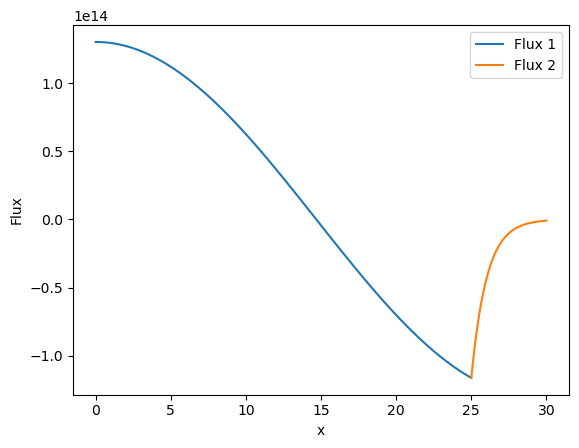

In [12]:
# Get phi1 and phi2 from solution
# phi1 = solution[0][0]
# phi2 = solution[0][1]
# phi3 = solution[0][2]
from sympy import sin, cos, sinh, cosh, tanh, exp

# Extract phi1, phi2, and phi3 from solution
phi1 = 130117372087005.0*cos(0.106947744680855*x) #34746968036852.0*cos(0.062831853071796*x) -100911257256110.0*cos(0.188495559215388*x)
phi2 = -4.62760798561332e+24*exp(-0.976333324543103*x) #-2236138351012.0*sinh(0.976333324543103*x - 24.4083331135776) -19482407687476.8*sinh(0.976333324543103*x - 24.4083331135776)
phi3 = 0 #2064363323787.3*sp.sinh(1.00807365802306*x - 50.4036829011532)/sp.tanh(1.00807365802306*x - 50.4036829011532) + 2064363323787.3*sp.cosh(1.00807365802306*x - 50.4036829011532)

fluxes_solved = [phi1, phi2, phi3]

# Display the results
for flux in fluxes_solved:
    display(Latex(f"${sp.latex(flux)}$"))

# Plot the results from x=0 to x=50
import numpy as np
import matplotlib.pyplot as plt
from sympy import lambdify



x_sym = sp.symbols('x')
x_1 = np.linspace(0, 25, 100)
x_2 = np.linspace(25, 30, 100)
x_3 = np.linspace(100, 150, 100)
phi1_vals = [phi1.subs(x, val).evalf() for val in x_1]
phi2_vals = [phi2.subs(x, val).evalf() for val in x_2]
#phi3_vals = [phi3.subs(x, val).evalf() for val in x_3]

plt.plot(x_1, phi1_vals, label='Flux 1')
plt.plot(x_2, phi2_vals, label='Flux 2')
#plt.plot(x_3, phi3_vals, label='Flux 3')
plt.xlabel('x')
plt.ylabel('Flux')
plt.legend()
plt.show()